
Cleaned Fret 1:
  Frequency: 428.57 Hz, Magnitude: -11.01 dB
  Frequency: 642.86 Hz, Magnitude: 2.66 dB
  Frequency: 1000.00 Hz, Magnitude: 3.92 dB
  Frequency: 1357.14 Hz, Magnitude: -2.78 dB
  Frequency: 1642.86 Hz, Magnitude: 8.92 dB
  Frequency: 2000.00 Hz, Magnitude: -0.52 dB
  Frequency: 2285.71 Hz, Magnitude: 4.60 dB
  Frequency: 2642.86 Hz, Magnitude: 7.41 dB
  Frequency: 3000.00 Hz, Magnitude: 2.35 dB
  Frequency: 3285.71 Hz, Magnitude: 5.97 dB

Cleaned Fret 2:
  Frequency: 357.14 Hz, Magnitude: 3.44 dB
  Frequency: 642.86 Hz, Magnitude: 10.22 dB
  Frequency: 1000.00 Hz, Magnitude: 8.99 dB
  Frequency: 1357.14 Hz, Magnitude: 6.63 dB
  Frequency: 1642.86 Hz, Magnitude: 8.37 dB
  Frequency: 2000.00 Hz, Magnitude: 9.86 dB
  Frequency: 2285.71 Hz, Magnitude: 8.09 dB
  Frequency: 2642.86 Hz, Magnitude: 3.13 dB
  Frequency: 3000.00 Hz, Magnitude: 2.50 dB
  Frequency: 3285.71 Hz, Magnitude: -0.10 dB

Cleaned Fret 3:
  Frequency: 357.14 Hz, Magnitude: 1.92 dB
  Frequency: 642.86 Hz, 

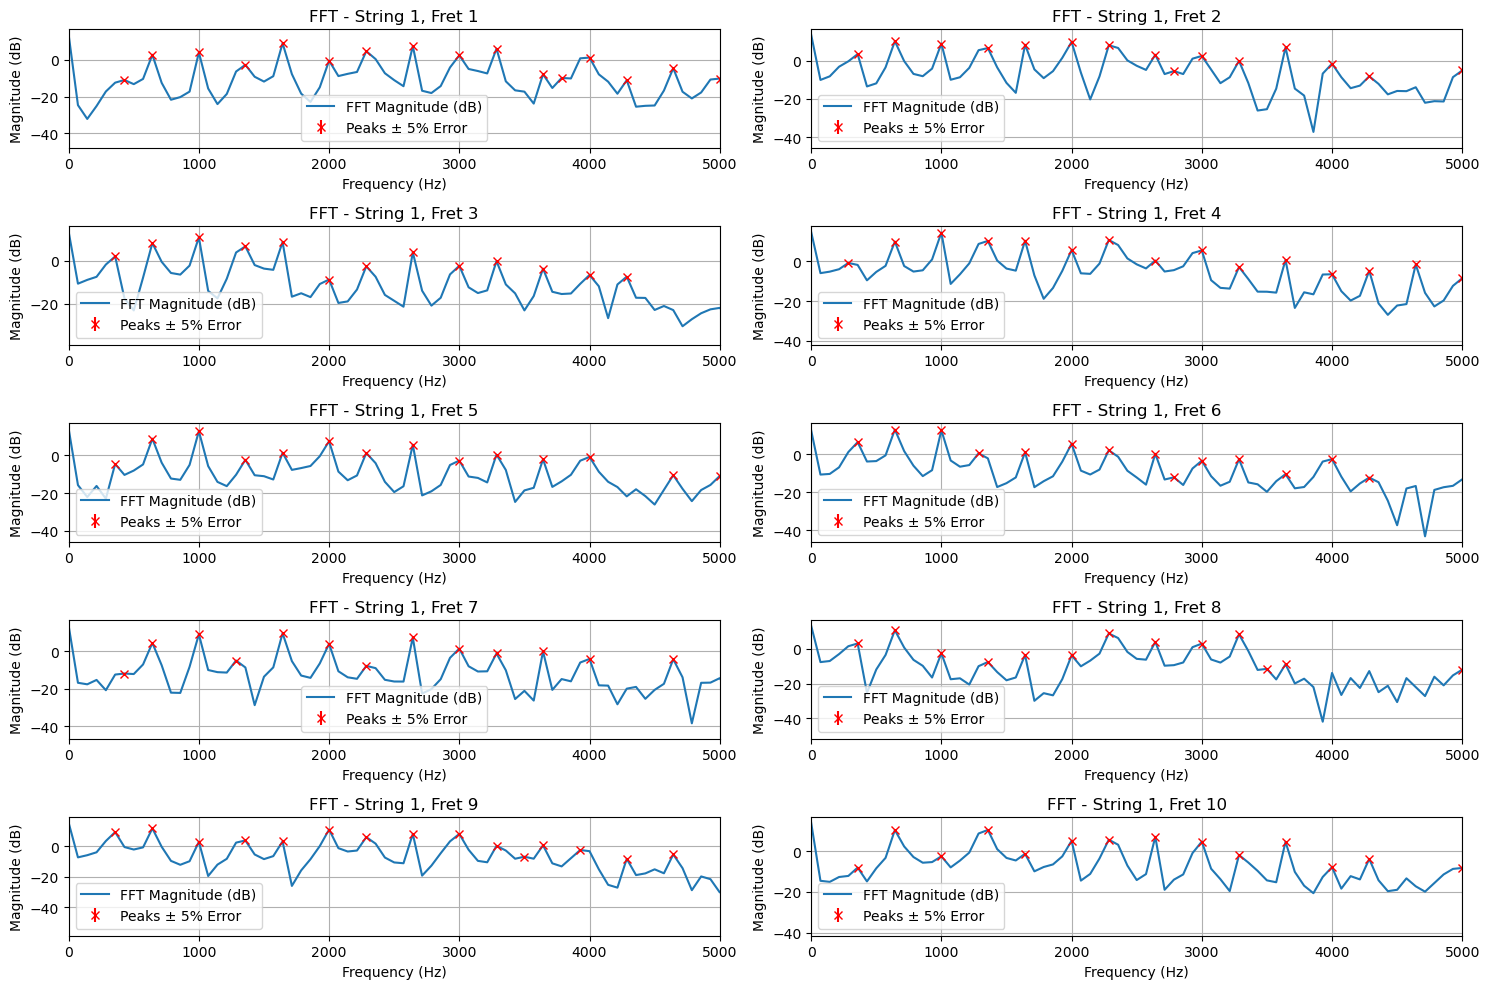

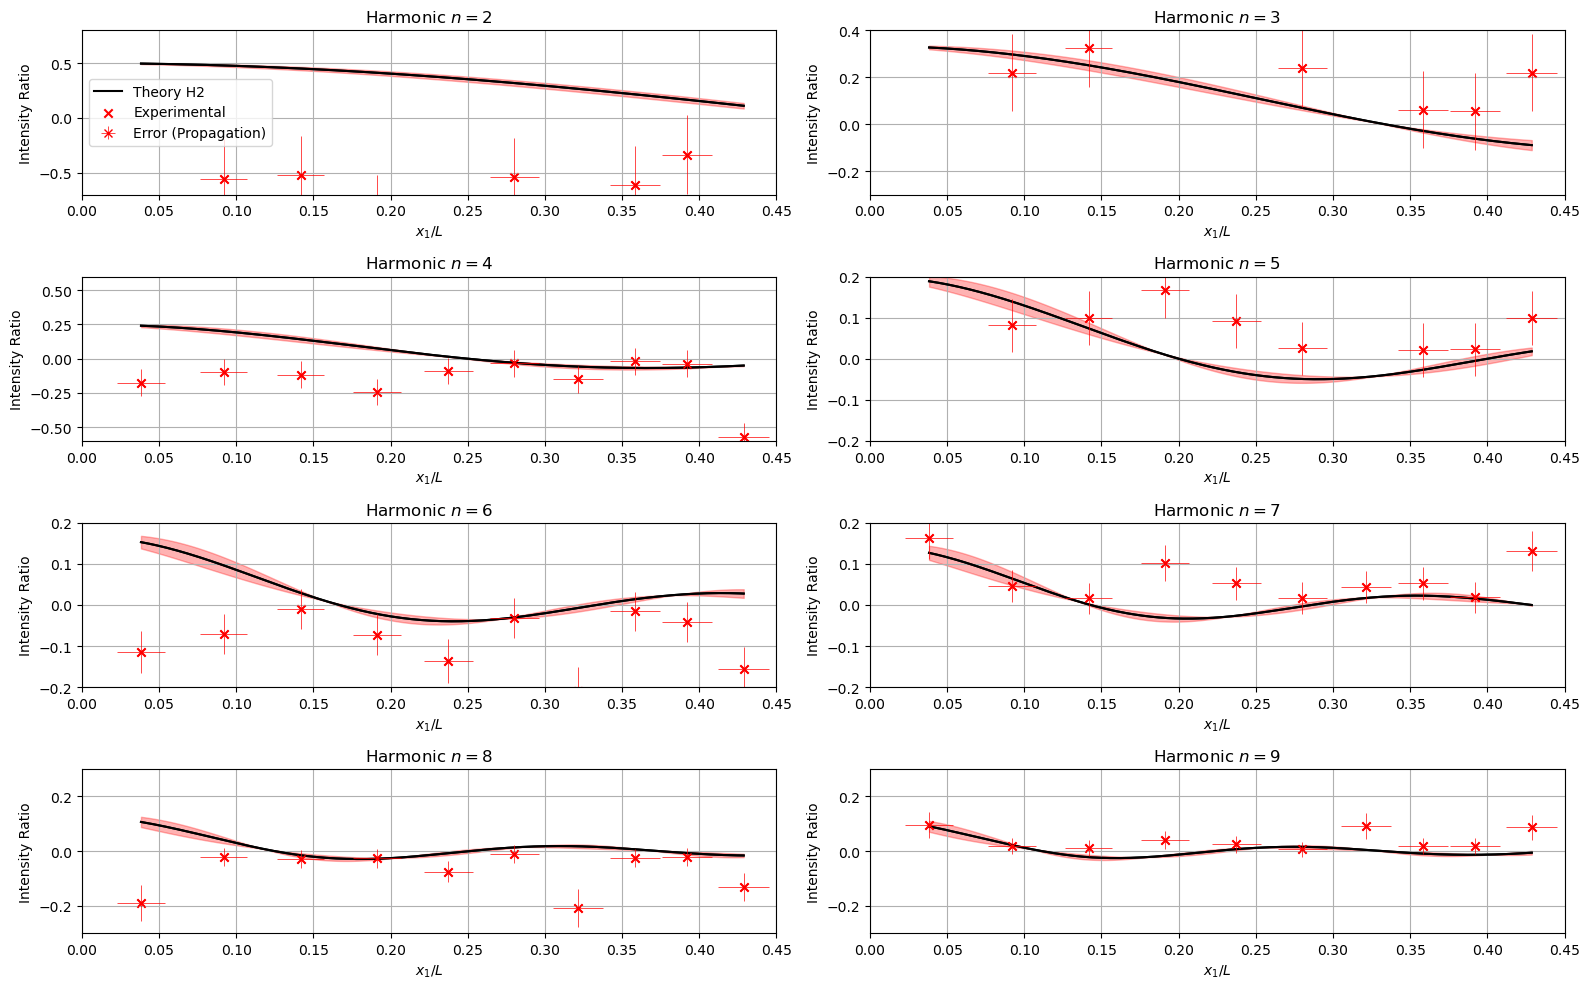

data!!! Fret 1, Chi2Stat: 1.5313051388636936
data!!! Fret 2, Chi2Stat: 0.7368401002031413
data!!! Fret 3, Chi2Stat: 0.9539958594295715
data!!! Fret 4, Chi2Stat: 2.8091957249732524
data!!! Fret 5, Chi2Stat: 5.029280001446219
data!!! Fret 6, Chi2Stat: 4.028755878401504
data!!! Fret 7, Chi2Stat: 1.8901192201256305
data!!! Fret 8, Chi2Stat: 3.08436282750744
data!!! Fret 9, Chi2Stat: 2.1149538444106337
data!!! Fret 10, Chi2Stat: 4.975252548919868


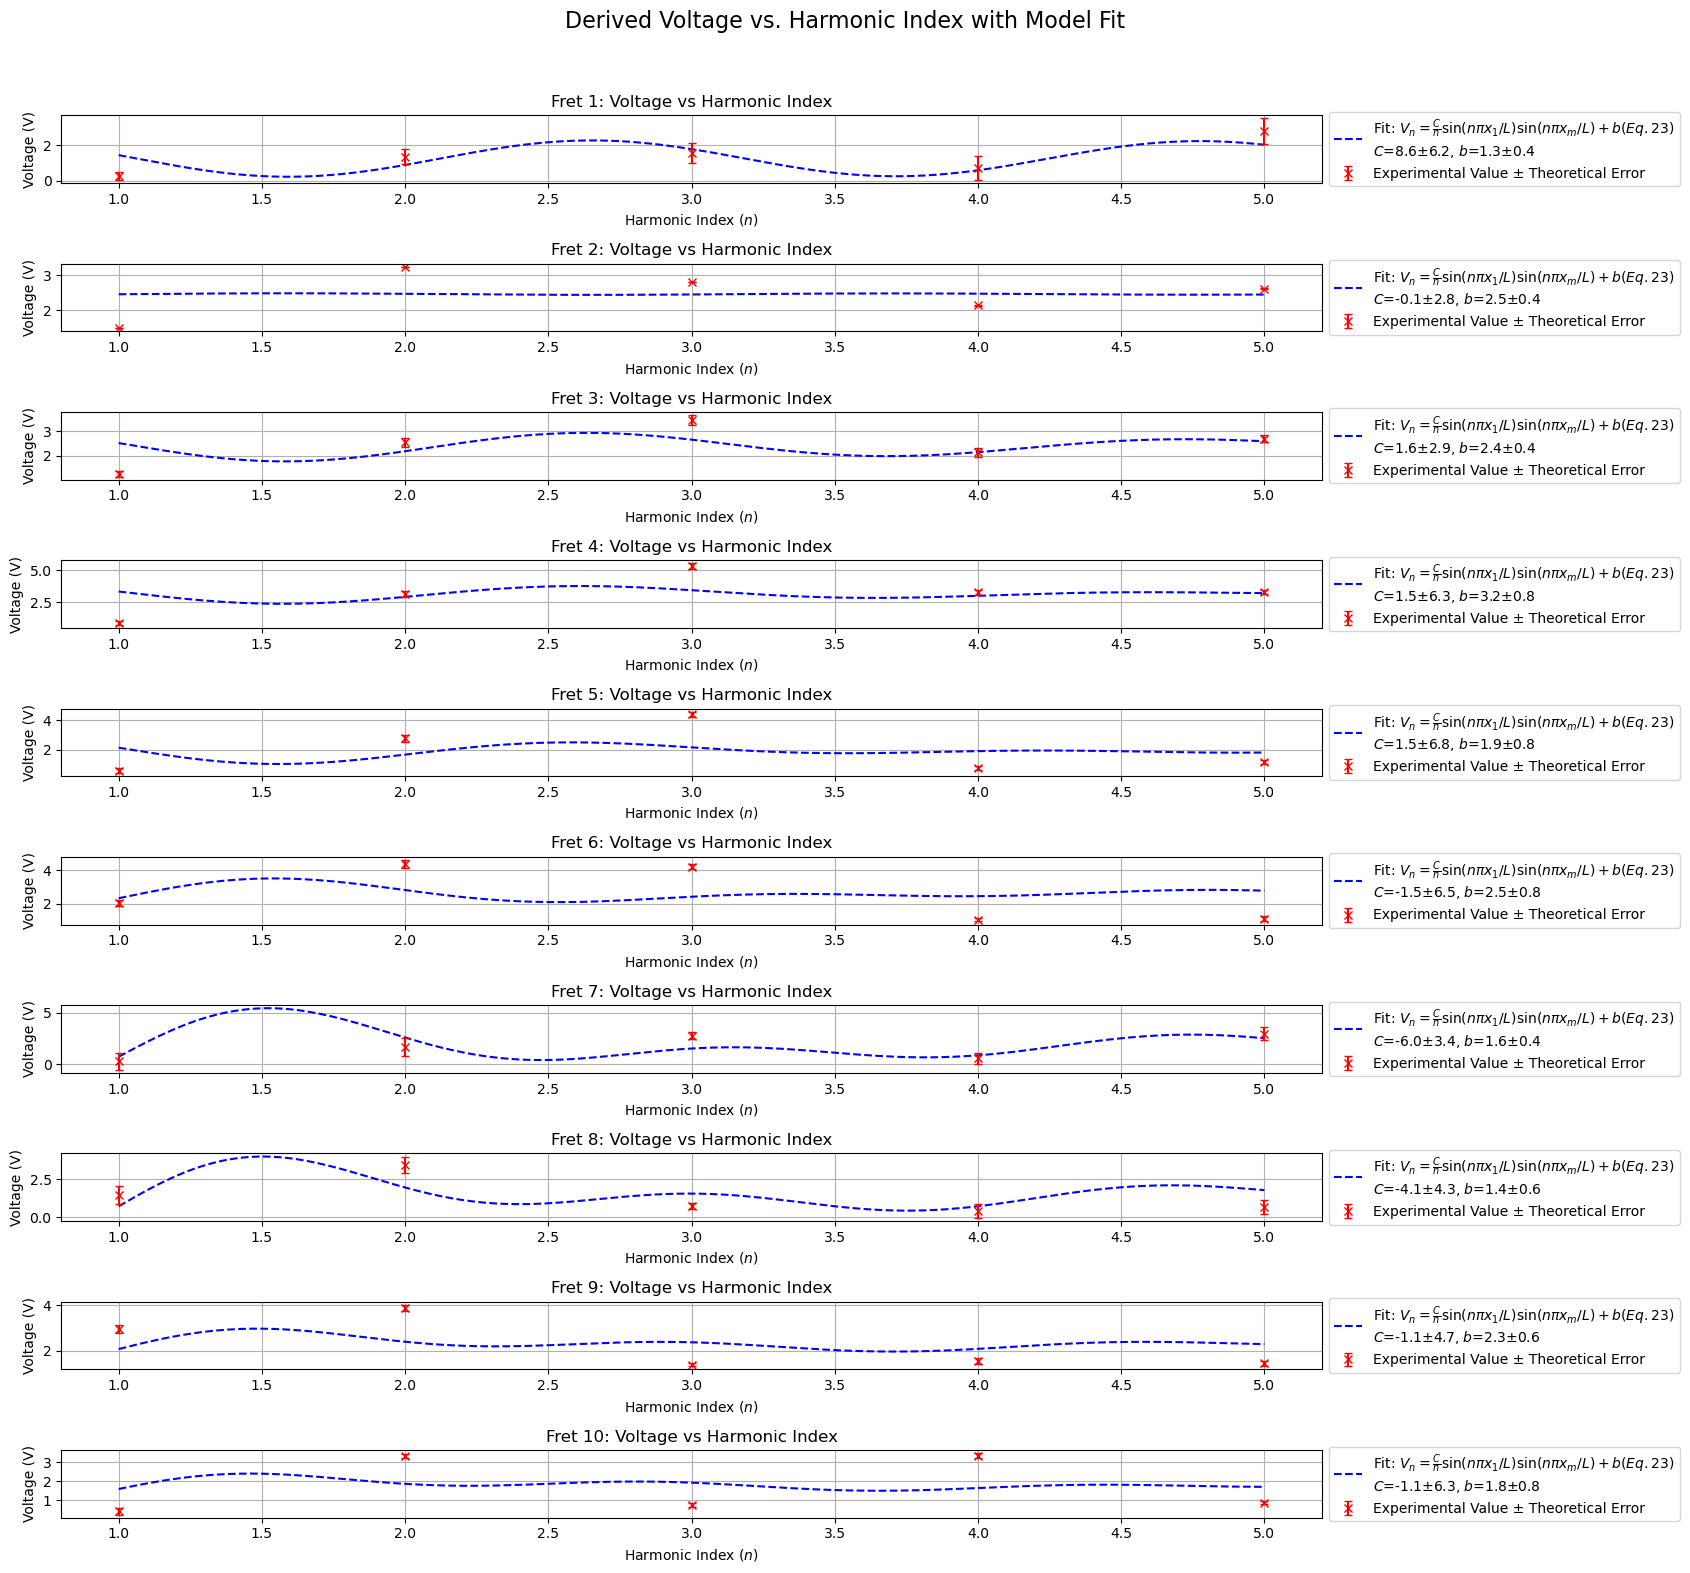


Reduced Chi-squared values for Voltage Fit by Fret (from valid fit points): {1: 0.5104350462878978, 2: 0.24561336673438042, 3: 0.31799861980985716, 4: 0.9363985749910841, 5: 1.6764266671487398, 6: 1.3429186261338346, 7: 0.6300397400418768, 8: 1.02812094250248, 9: 0.7049846148035446, 10: 1.6584175163066226}
--- Script Execution Finished ---


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import make_interp_spline
from numpy import sin 
from numpy import cos 
from scipy.optimize import curve_fit
from scipy.stats import chisquare 

file_list= {
    1: ['11.csv', '12.csv'], 
    2: ['21.csv', '22.csv'],
    3: ['31.csv', '32.csv'], 
    4: ['41.csv', '42.csv'], 
    5: ['51.csv', '52.csv'], 
    6: ['61.csv', '62.csv'], 
    7: ['71.csv', '72.csv'], 
    8: ['81.csv', '82.csv'], 
    9: ['91.csv', '92.csv'],
    10: ['101.csv', '102.csv']
}
distances = {
    1: (0.025, 0.038284), 2: (0.06, 0.0918836),
    3: (0.0925, 0.14165390), 4: (0.125, 0.19142419),
    5: (0.155, 0.237366), 6: (0.183, 0.280245),
    7: (0.21, 0.3215926), 8: (0.234, 0.358346),
    9: (0.256, 0.3920367), 10: (0.28, 0.4287901)
}
x_m = 0.615
L = 0.653
dt = 10**-5
expected_f0 = 330
frequency = 1 / dt 
sensitivity = 0.05 
tolerance = 100 


DB_MAG_PLACEHOLDER = -100.0 # Using a very low dB for missing harmonics

def read_and_average_signals(current_file_list_param): 
    signals = []
    for filename in current_file_list_param:
        try:
            data = np.loadtxt(filename, delimiter=',', skiprows=2, usecols=1)
            signals.append(data)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
    return np.mean(signals, axis=0) if signals else np.array([])

def get_fft_and_peaks(signal, dt_param, sensitivity_param):
    if not signal.any(): # Check if signal has any elements
        return np.array([]), np.array([]), np.array([]), np.array([]) # Return empty arrays
    N = len(signal)
    freq_axis = np.fft.rfftfreq(N, dt_param) 
    fft_result_val = np.fft.rfft(signal) 
    magnitude_linear_spectrum = np.abs(fft_result_val) 
    magnitude_db_spectrum = 20 * np.log10(magnitude_linear_spectrum + 1e-12) 
    

    peak_indices_arr, _ = find_peaks(magnitude_linear_spectrum, height=np.max(magnitude_linear_spectrum) * sensitivity_param, distance=2) # Renamed, was peaks
    
    # Returns: freq_axis, full LINEAR magnitude spectrum, full DB magnitude spectrum, peak INDICES
    return freq_axis, magnitude_linear_spectrum, magnitude_db_spectrum, peak_indices_arr

def clean_harmonics(peaks_input_data, current_expected_f0, current_tolerance): # peaks_input_data will be (freq, mag_DB)
    # If peaks_input_data is empty, create placeholders
    if not peaks_input_data:
        output_harmonics_db = []
        for n_h_idx in range(1, 11):
            output_harmonics_db.append((current_expected_f0 * n_h_idx, DB_MAG_PLACEHOLDER))
        return output_harmonics_db

    # Unpack (freq, mag_DB)
    input_freqs, input_mags_db = zip(*peaks_input_data) 
    
    output_harmonics_db = [] # This will store (freq, mag_DB)
    for n_val in range(1, 11):
        target_freq_val = current_expected_f0 * n_val
        if not input_freqs:
            output_harmonics_db.append((target_freq_val, DB_MAG_PLACEHOLDER))
            continue

        diffs_val = np.abs(np.array(input_freqs) - target_freq_val)
        
        if diffs_val.size > 0 and np.min(diffs_val) < current_tolerance: # Check diffs_val is not empty
            idx_val = np.argmin(diffs_val)
            output_harmonics_db.append((input_freqs[idx_val], input_mags_db[idx_val])) # Store the input dB magnitude
        else:
            output_harmonics_db.append((target_freq_val, DB_MAG_PLACEHOLDER)) # Use dB placeholder
    return output_harmonics_db

def plot_fft_all_frets(peak_data_dict_db):
    fig, axs = plt.subplots(5, 2, figsize=(15, 10))

    
    for fret_idx in file_list: 
        row, col = (fret_idx - 1) // 2, (fret_idx - 1) % 2

        axs_current_plot = axs[row, col] 

        avg_signal_plot = read_and_average_signals(file_list[fret_idx])
        if not avg_signal_plot.any():
            axs_current_plot.text(0.5,0.5,"No Signal", ha='center',va='center')
            axs_current_plot.set_title(f"Fret {fret_idx} - No Signal")
            peak_data_dict_db[fret_idx] = [] # Ensure entry exists
            continue

        # freq_axis_plot, linear_mag_spectrum_plot, db_mag_spectrum_plot, peak_indices_plot
        freq_plot, mag_linear_plot, mag_db_plot, peaks_plot_indices = get_fft_and_peaks(avg_signal_plot, dt, sensitivity)
        
        peak_freqs_plot = freq_plot[peaks_plot_indices]
        peak_mags_linear_plot = mag_linear_plot[peaks_plot_indices] 
        
        sorted_idx_plot = np.argsort(peak_freqs_plot)
        peak_freqs_plot_sorted = peak_freqs_plot[sorted_idx_plot]
        peak_mags_linear_plot_sorted = peak_mags_linear_plot[sorted_idx_plot]

        # --- CHANGE POINT 1: Store dB magnitudes in peak_data_dict_db ---
        if peak_mags_linear_plot_sorted.size > 0:
            peak_mags_db_to_store = 20 * np.log10(peak_mags_linear_plot_sorted + 1e-12)
            peak_data_dict_db[fret_idx] = list(zip(peak_freqs_plot_sorted, peak_mags_db_to_store))
        else:
            peak_data_dict_db[fret_idx] = []

        axs_current_plot.plot(freq_plot, mag_db_plot, label='FFT Magnitude (dB)') # Plot full spectrum in dB

        if peak_mags_linear_plot_sorted.size > 0: 
            peak_errors_linear_plot = 0.05 * peak_mags_linear_plot_sorted 
            valid_err_mask_plot = peak_mags_linear_plot_sorted > 1e-12
            peak_errors_db_for_plot = np.zeros_like(peak_mags_linear_plot_sorted, dtype=float) # Ensure float for NaNs if any
            if np.any(valid_err_mask_plot):
                 peak_errors_db_for_plot[valid_err_mask_plot] = (20 / np.log(10)) * \
                    (peak_errors_linear_plot[valid_err_mask_plot] / peak_mags_linear_plot_sorted[valid_err_mask_plot])
            
            # Use the already converted dB magnitudes for y-values of errorbar
            # These are the values stored in peak_data_dict_db[fret_idx]
            if peak_data_dict_db[fret_idx]: # Check if list is not empty
                _, current_peak_mags_db_for_plot = zip(*peak_data_dict_db[fret_idx])
                axs_current_plot.errorbar(peak_freqs_plot_sorted, current_peak_mags_db_for_plot, 
                                          yerr=peak_errors_db_for_plot, fmt='x', color='red', label='Peaks ± 5% Error')

        axs_current_plot.set_title(f"FFT - String 1, Fret {fret_idx}")
        axs_current_plot.set_xlabel("Frequency (Hz)")
        axs_current_plot.set_ylabel("Magnitude (dB)")
        axs_current_plot.grid(True)
        axs_current_plot.set_xlim([0, 5000])
        axs_current_plot.legend()

    plt.tight_layout()
    plt.savefig("Fourier_transform.png")


def plot_harmonic_intensity_ratio(cleaned_data_input_db): # Input is now (freq, mag_dB)

    ratios_as_db = np.full((11,10), DB_MAG_PLACEHOLDER) # Store dB magnitudes, init with placeholder

    for fret_ratios_idx in cleaned_data_input_db.keys():

        for i_ratios, (freq_r_val, mag_r_db_val) in enumerate(cleaned_data_input_db[fret_ratios_idx]):

            if i_ratios < 10: # Store up to 10 harmonics
                ratios_as_db[fret_ratios_idx, i_ratios] = mag_r_db_val # Storing dB
    
    x_values_ratio_plot = [x_dist[1] for x_dist in distances.values()]  # x/L values (distances is global)
    x_values_doi_ratio_plot =  [x_dist[0] for x_dist in distances.values()] # x1 actual (distances is global)

    fig, axs = plt.subplots(4, 2, figsize=(16, 10))

    for n_plot_ratio in range(2, 10):
        y_values_t_ratio = []
        for x_ratio_val_t in x_values_ratio_plot:
            denom_t_ratio = (n_plot_ratio**2 * np.sin(np.pi * x_ratio_val_t))
            if abs(denom_t_ratio) < 1e-9: y_values_t_ratio.append(np.nan)
            else: y_values_t_ratio.append(np.sin(n_plot_ratio * np.pi * x_ratio_val_t) / denom_t_ratio)

        # Experimental values
        y_values_e_ratio = []
        erroare_int_osc = 1 *(np.sqrt(2))

        temp_ratie_B_x_m_list = [] 
        temp_ratie_B_L_list = []
                                        
        for fret_e_idx in range(1, 11):
            # Magnitudes are from ratios_as_db, which are in dB
            B_V_1_db_val_e = ratios_as_db[fret_e_idx, 0] # dB magnitude of H1
            # n_plot_ratio is H_n (n=2 to 9), so index in array is n_plot_ratio-1
            B_V_n_db_val_e = ratios_as_db[fret_e_idx, n_plot_ratio -1] 

            if B_V_1_db_val_e == DB_MAG_PLACEHOLDER or B_V_n_db_val_e == DB_MAG_PLACEHOLDER:
                y_values_e_ratio.append(np.nan)
                temp_ratie_B_x_m_list.append(np.nan) 
                temp_ratie_B_L_list.append(np.nan)
                continue

            Vn_V1_linear_val_e = 10 ** ((B_V_n_db_val_e - B_V_1_db_val_e) / 20.0)
            
            # Using global x_m, L
            denom_factor2_e = np.sin(n_plot_ratio * np.pi * x_m / L) 
            if abs(denom_factor2_e) < 1e-9:
                Bn_B1_val_e = np.nan
            else:
                factor_2_e = (1 / n_plot_ratio) * (np.sin(np.pi * x_m / L) / denom_factor2_e)
                Bn_B1_val_e = Vn_V1_linear_val_e * factor_2_e
            y_values_e_ratio.append(Bn_B1_val_e)

            denom_deriv_xm_e = (n_plot_ratio * L * (np.sin(n_plot_ratio * np.pi * x_m/L))**2 )
            denom_deriv_l_e = (n_plot_ratio *(L**2) * (np.sin(n_plot_ratio * np.pi * x_m/L))**2 )

            if abs(denom_deriv_xm_e)<1e-9 or abs(denom_deriv_l_e)<1e-9 or np.isnan(Vn_V1_linear_val_e):
                temp_ratie_B_x_m_list.append(np.nan)
                temp_ratie_B_L_list.append(np.nan)
            else:
                term_cos_sin_e = cos(np.pi *x_m /L)* sin(n_plot_ratio* np.pi *x_m /L)
                term_sin_cos_e = sin(np.pi *x_m /L) * cos(np.pi*n_plot_ratio *x_m /L)
                temp_ratie_B_x_m_list.append(Vn_V1_linear_val_e * np.pi / denom_deriv_xm_e * (term_cos_sin_e - n_plot_ratio* term_sin_cos_e) )
                temp_ratie_B_L_list.append(- Vn_V1_linear_val_e * np.pi * x_m / denom_deriv_l_e * (term_cos_sin_e - n_plot_ratio* term_sin_cos_e) )
        
        row_idx_ratio, col_idx_ratio = (n_plot_ratio - 2) // 2, (n_plot_ratio - 2) % 2
        axs_current_ratio_plot = axs[row_idx_ratio, col_idx_ratio]

        # Smooth theoretical curve
        valid_theory_mask_ratio = ~np.isnan(y_values_t_ratio)
        if np.sum(valid_theory_mask_ratio) > 3: # Check for enough points for spline
            x_t_valid_ratio = np.array(x_values_ratio_plot)[valid_theory_mask_ratio]
            y_t_valid_ratio = np.array(y_values_t_ratio)[valid_theory_mask_ratio]
            sort_t_idx_ratio = np.argsort(x_t_valid_ratio) # Sort before spline
            x_t_valid_sorted_ratio = x_t_valid_ratio[sort_t_idx_ratio]
            y_t_valid_sorted_ratio = y_t_valid_ratio[sort_t_idx_ratio]

            x_smooth_ratio = np.linspace(min(x_t_valid_sorted_ratio), max(x_t_valid_sorted_ratio), 300)
            spline_ratio = make_interp_spline(x_t_valid_sorted_ratio, y_t_valid_sorted_ratio, k=3) # k=3 for cubic
            y_smooth_ratio = spline_ratio(x_smooth_ratio)
            axs_current_ratio_plot.plot(x_smooth_ratio, y_smooth_ratio, color='black', label=f'Theory H{n_plot_ratio}')
            
            # Error on theoretical curve
            error_th_ratio_calc = np.zeros_like(x_smooth_ratio) 
            for t_idx_err_ratio, x_s_val_err_ratio in enumerate(x_smooth_ratio):
                sin_pi_x_L_err_ratio = np.sin(np.pi * x_s_val_err_ratio / L) # L is global
                if abs(sin_pi_x_L_err_ratio) < 1e-9:
                    error_th_ratio_calc[t_idx_err_ratio] = np.nan; continue
                term1_ratio = (cos(n_plot_ratio*np.pi*x_s_val_err_ratio/L)*n_plot_ratio*np.pi/L*sin_pi_x_L_err_ratio - sin(n_plot_ratio*np.pi*x_s_val_err_ratio/L)*cos(np.pi*x_s_val_err_ratio/L)*np.pi/L) / (sin_pi_x_L_err_ratio**2)
                term2_ratio = (-cos(n_plot_ratio*np.pi*x_s_val_err_ratio/L)*n_plot_ratio*np.pi*x_s_val_err_ratio/(L**2)*sin_pi_x_L_err_ratio + sin(n_plot_ratio*np.pi*x_s_val_err_ratio/L)*cos(np.pi*x_s_val_err_ratio/L)*np.pi*x_s_val_err_ratio/(L**2)) / (sin_pi_x_L_err_ratio**2)
                error_th_ratio_calc[t_idx_err_ratio] = np.sqrt(((0.01*(1/n_plot_ratio)**2*term1_ratio)**2) + ((0.01*(1/n_plot_ratio)**2*term2_ratio)**2))

            valid_err_th_mask_ratio = ~np.isnan(error_th_ratio_calc) & ~np.isnan(y_smooth_ratio)
            axs_current_ratio_plot.fill_between(x_smooth_ratio[valid_err_th_mask_ratio],
                                 y_smooth_ratio[valid_err_th_mask_ratio] + error_th_ratio_calc[valid_err_th_mask_ratio],
                                 y_smooth_ratio[valid_err_th_mask_ratio] - error_th_ratio_calc[valid_err_th_mask_ratio],
                                 alpha=0.3, color='red')
            axs_current_ratio_plot.plot(x_smooth_ratio, y_smooth_ratio, color='black') # Replot line
        else: # Not enough points for spline, plot raw theory points
            axs_current_ratio_plot.plot(x_values_ratio_plot, y_values_t_ratio, color='black', linestyle='--', marker='.', label=f'Theory H{n_plot_ratio} (pts)')


        # Experimental data with errors
        errors_x_plot_e = np.zeros(len(x_values_ratio_plot))
        errors_y_plot_e = np.zeros(len(x_values_ratio_plot))
        ratie_B_V_for_error_calc = sin(np.pi * x_m /L) / (n_plot_ratio * sin(np.pi * n_plot_ratio * x_m/L)) # L, x_m global

        for n_ind_err_e_plot in range(len(x_values_ratio_plot)):
            if x_values_doi_ratio_plot[n_ind_err_e_plot] == 0: errors_x_plot_e[n_ind_err_e_plot] = np.nan
            else: errors_x_plot_e[n_ind_err_e_plot] = x_values_ratio_plot[n_ind_err_e_plot] * np.sqrt((0.01 / x_values_doi_ratio_plot[n_ind_err_e_plot])**2 + (0.01 / L)**2)
            
            # This relies on temp_ratie_B_x_m_list, temp_ratie_B_L_list which are derivatives.
            # The term (erroare_int_osc * ratie_B_V_for_error_calc) is tricky if erroare_int_osc is dB error
            # and ratie_B_V_for_error_calc is linear. This part is kept as is.
            if np.isnan(temp_ratie_B_x_m_list[n_ind_err_e_plot]) or np.isnan(temp_ratie_B_L_list[n_ind_err_e_plot]):
                errors_y_plot_e[n_ind_err_e_plot] = np.nan
            else:
                 errors_y_plot_e[n_ind_err_e_plot] = np.sqrt( (erroare_int_osc * ratie_B_V_for_error_calc )**2 + \
                                                            (0.01 * temp_ratie_B_x_m_list[n_ind_err_e_plot]  )**2 + \
                                                            (0.01 * temp_ratie_B_L_list[n_ind_err_e_plot])**2 )   

        valid_exp_mask_ratio_plot = ~np.isnan(y_values_e_ratio) & ~np.isnan(errors_y_plot_e) & ~np.isnan(errors_x_plot_e)
        if np.any(valid_exp_mask_ratio_plot):
            axs_current_ratio_plot.errorbar(np.array(x_values_ratio_plot)[valid_exp_mask_ratio_plot],
                             np.array(y_values_e_ratio)[valid_exp_mask_ratio_plot],
                             xerr=np.array(errors_x_plot_e)[valid_exp_mask_ratio_plot],
                             yerr=np.array(errors_y_plot_e)[valid_exp_mask_ratio_plot],
                             fmt='x', color='red', label="Error (Propagation)", linestyle='None', elinewidth=0.5)
        else:
            axs_current_ratio_plot.text(0.5,0.4,"No Valid Exp. Data/Error", ha='center',va='center',transform=axs_current_ratio_plot.transAxes)
        
        # Scatter plot of experimental points
        axs_current_ratio_plot.scatter(x_values_ratio_plot, (np.array(y_values_e_ratio)), color='red', label="Experimental", marker='x')


        axs_current_ratio_plot.set_title(f"Harmonic $n = {n_plot_ratio}$")
        axs_current_ratio_plot.set_xlabel("$x_1/L$") # x_values are x/L
        axs_current_ratio_plot.set_ylabel("Intensity Ratio") # y_values are intensity ratio
        axs_current_ratio_plot.set_xlim((0,0.45))
        axs_current_ratio_plot.set_ylim((-0.2,0.2))
        axs_current_ratio_plot.grid(True)
        
        if row_idx_ratio == 0 and col_idx_ratio == 0: axs_current_ratio_plot.set_ylim((-0.7,0.8))
        if row_idx_ratio == 1 and col_idx_ratio == 0: axs_current_ratio_plot.set_ylim((-0.6,0.6))
        if row_idx_ratio == 0 and col_idx_ratio == 1: axs_current_ratio_plot.set_ylim((-0.3,0.4))
        if row_idx_ratio == 3 and col_idx_ratio == 0: axs_current_ratio_plot.set_ylim((-0.3,0.3))
        if row_idx_ratio == 3 and col_idx_ratio == 1: axs_current_ratio_plot.set_ylim((-0.3,0.3))

    plt.tight_layout()

    axs[0,0].legend() # Add legend to at least one subplot if not all
    plt.savefig("Intensity_ratio.png")
    plt.show()

def plot_voltage_vs_frequency_with_theory(cleaned_data_db_voltage, L_plot_volt=0.653, x_m_plot_volt=0.615, delta_L_plot_volt=0.03, delta_xm_plot_volt=0.02, delta_x1_plot_volt=0.02): # Params renamed
    fig, axs = plt.subplots(10, 1, figsize=(17, 16)) 
    axs = axs.flatten() # This is fine for 10,1 as it becomes a 1D array of 10 plots

    fret_to_x1_cm_volt = { # Renamed
        1: 2.5, 2: 6.0, 3: 9.25, 4: 12.5, 5: 15.5,
        6: 18.3, 7: 21.0, 8: 23.4, 9: 25.6, 10: 28.0
    }
    all_chi2_results_volt = {}

    for fret_volt_idx in range(1, 11): 
        ax_volt_plot = axs[fret_volt_idx - 1] # For flattened axs
        x1_volt_plot = fret_to_x1_cm_volt[fret_volt_idx] / 100.0 # Convert cm to m

        if fret_volt_idx not in cleaned_data_db_voltage or not cleaned_data_db_voltage[fret_volt_idx]:
            ax_volt_plot.text(0.5,0.5,"No Cleaned Data", ha='center', va='center')
            ax_volt_plot.set_title(f"Fret {fret_volt_idx} - No Data")
            continue
        
        num_harmonics_volt_plot = min(len(cleaned_data_db_voltage[fret_volt_idx]), 5)
        if num_harmonics_volt_plot == 0:
            ax_volt_plot.text(0.5,0.5,"0 Harmonics", ha='center', va='center')
            ax_volt_plot.set_title(f"Fret {fret_volt_idx} - 0 Harmonics")
            continue

        harmonics_data_to_plot = cleaned_data_db_voltage[fret_volt_idx][:num_harmonics_volt_plot]
        # freqs_volt_plot, mags_db_volt_plot = zip(*harmonics_data_to_plot) # freqs_volt_plot not used for model
        _, mags_db_volt_plot = zip(*harmonics_data_to_plot) # mags_db_volt_plot ARE in dB

        voltages_linear_for_fit = np.array([10 ** (mag_db_item_volt / 20.0) if mag_db_item_volt != DB_MAG_PLACEHOLDER else 0 for mag_db_item_volt in mags_db_volt_plot])
        
        harmonic_indices_for_fit_plot = np.array(range(1, len(voltages_linear_for_fit) + 1))
        
        # Filter for fitting (remove placeholders that became 0)
        valid_volt_mask_plot = voltages_linear_for_fit > 1e-9 
        harmonic_indices_actually_fit = harmonic_indices_for_fit_plot[valid_volt_mask_plot]
        voltages_linear_actually_fit = voltages_linear_for_fit[valid_volt_mask_plot]

        if len(voltages_linear_actually_fit) < 2 : # Need at least 2 points for C and b
            ax_volt_plot.text(0.5,0.4, f"Fit failed: <2 valid pts ({len(voltages_linear_actually_fit)})", ha='center', va='center', color='gray')
            ax_volt_plot.scatter(harmonic_indices_for_fit_plot, voltages_linear_for_fit, color='gray', marker='o', label="Data (Placeholders/Not Fit)") # Plot original points
            ax_volt_plot.set_title(f"Fret {fret_volt_idx} - Fit Failed")
            ax_volt_plot.legend()
            continue

        def model_volt_fit(n_model_param, C_param, b_param): # Model uses linear voltage
            # Using L_plot_volt, x_m_plot_volt, x1_volt_plot from function scope
            return (C_param / n_model_param) * np.sin(n_model_param * np.pi * x1_volt_plot / L_plot_volt) * \
                   np.sin(n_model_param * np.pi * x_m_plot_volt / L_plot_volt) + b_param

        C_fit_val_volt, b_fit_val_volt = np.nan, np.nan 
        error_C_val_volt, error_b_val_volt = np.nan, np.nan
        try:
            popt_val_volt, pcov_val_volt = curve_fit(model_volt_fit, harmonic_indices_actually_fit, voltages_linear_actually_fit, p0=(1, 0.001), maxfev=10000)
            error_C_val_volt, error_b_val_volt = np.sqrt(np.diag(pcov_val_volt))
            C_fit_val_volt, b_fit_val_volt = popt_val_volt
            
            n_smooth_volt_plot = np.linspace(min(harmonic_indices_actually_fit), max(harmonic_indices_actually_fit), 200)
            if n_smooth_volt_plot.size == 0 : n_smooth_volt_plot = np.array([1.0]) # Handle edge case
            Vn_fit_smooth_val_volt = model_volt_fit(n_smooth_volt_plot, C_fit_val_volt, b_fit_val_volt)
            
            ax_volt_plot.plot(n_smooth_volt_plot, Vn_fit_smooth_val_volt, color='blue', linestyle='--', label=(
                r"Fit: $V_n = \frac{C}{n}\sin(n\pi x_1/L)\sin(n\pi x_m/L) + b (Eq. 23)$"
                f"\n$C$={C_fit_val_volt:.1f}±{error_C_val_volt:.1f}, $b$={b_fit_val_volt:.1f}±{error_b_val_volt:.1f}"))
            
        except Exception as e_volt_fit_main:
            ax_volt_plot.text(0.5, 0.4, f"Fit failed\n{e_volt_fit_main}", transform=ax_volt_plot.transAxes, ha='center', va='center', color='gray', fontsize=8)

        theory_errors_at_exp_volt_list = []
        if not (np.isnan(C_fit_val_volt) or np.isnan(b_fit_val_volt) or np.isnan(error_C_val_volt) or np.isnan(error_b_val_volt)): # Check all
            for n_exp_val_err_volt in harmonic_indices_actually_fit: # Iterate through the indices used for fit
                A_err_volt = n_exp_val_err_volt * np.pi * x1_volt_plot / L_plot_volt
                B_err_volt = n_exp_val_err_volt * np.pi * x_m_plot_volt / L_plot_volt
                
                # These operate on linear C_fit_val_volt
                dV_dx1_err_volt = (C_fit_val_volt * np.pi / L_plot_volt) * np.cos(A_err_volt) * np.sin(B_err_volt)
                dV_dxm_err_volt = (C_fit_val_volt * np.pi / L_plot_volt) * np.sin(A_err_volt) * np.cos(B_err_volt)
                dV_dL_err_volt = -(C_fit_val_volt * np.pi / (L_plot_volt**2)) * \
                                 (x1_volt_plot * np.cos(A_err_volt) * np.sin(B_err_volt) + x_m_plot_volt * np.sin(A_err_volt) * np.cos(B_err_volt))
                
                # For "no other changes", error from fit params C,b is not added here.
                error_sq_volt_calc = (dV_dx1_err_volt * delta_x1_plot_volt)**2 + \
                                     (dV_dxm_err_volt * delta_xm_plot_volt)**2 + \
                                     (dV_dL_err_volt * delta_L_plot_volt)**2
                theory_errors_at_exp_volt_list.append(np.sqrt(max(0, error_sq_volt_calc))) # Ensure non-negative
        
        # Plot experimental points that were fit
        if len(harmonic_indices_actually_fit) > 0:
            if len(theory_errors_at_exp_volt_list) == len(harmonic_indices_actually_fit):
                ax_volt_plot.errorbar(harmonic_indices_actually_fit, voltages_linear_actually_fit, 
                                 yerr=theory_errors_at_exp_volt_list, fmt='x', color='red', capsize=3, label='Experimental Value ± Theoretical Error')
            else: # Error calculation mismatch
                ax_volt_plot.scatter(harmonic_indices_actually_fit, voltages_linear_actually_fit, color='red', marker='x', label="Experimental (Fit) (Err mismatch)")
        
        '''if np.any(placeholder_mask_volt_plot):
            ax_volt_plot.scatter(harmonic_indices_for_fit_plot[placeholder_mask_volt_plot], 
                                 voltages_linear_for_fit[placeholder_mask_volt_plot], 
                                 color='orange', marker='o', s=15, label="Placeholders (Not Fit)", alpha=0.6)'''


        ax_volt_plot.set_title(f"Fret {fret_volt_idx}: Voltage vs Harmonic Index") 
        ax_volt_plot.set_xlabel("Harmonic Index ($n$)")
        ax_volt_plot.set_ylabel("Voltage (V)") # Y-axis is linear voltage
        ax_volt_plot.grid(True)
        ax_volt_plot.legend(loc="center left", bbox_to_anchor=(1, 0.5)) 
            
        if not (np.isnan(C_fit_val_volt) or np.isnan(b_fit_val_volt)):
            # Chi2 against the points that were actually fit
            obs_data_for_chi2_volt = voltages_linear_actually_fit
            expected_data_for_chi2_volt = model_volt_fit(harmonic_indices_actually_fit, C_fit_val_volt, b_fit_val_volt)

            valid_chi2_mask_volt_plot = (obs_data_for_chi2_volt > 1e-9) & (expected_data_for_chi2_volt > 1e-9) & \
                                ~np.isnan(obs_data_for_chi2_volt) & ~np.isnan(expected_data_for_chi2_volt)
            
            obs_chi2_valid_volt_plot = obs_data_for_chi2_volt[valid_chi2_mask_volt_plot]
            exp_chi2_valid_volt_plot = expected_data_for_chi2_volt[valid_chi2_mask_volt_plot]

            if obs_chi2_valid_volt_plot.size > 2 and obs_chi2_valid_volt_plot.size == exp_chi2_valid_volt_plot.size: # ddof=2
                try:

                    chi2_result_tuple = chisquare(f_obs=obs_chi2_valid_volt_plot, f_exp=exp_chi2_valid_volt_plot, ddof=2)
                    print(f"data!!! Fret {fret_volt_idx}, Chi2Stat: {chi2_result_tuple[0]}")

                    if (len(obs_chi2_valid_volt_plot) - 2) > 0:
                        all_chi2_results_volt[fret_volt_idx] = chi2_result_tuple[0] / (len(obs_chi2_valid_volt_plot) - 2)
                except ValueError as e_chi2_final:
                     print(f"Chi2 calc error (final) Fret {fret_volt_idx}: {e_chi2_final}")


    fig.suptitle("Derived Voltage vs. Harmonic Index with Model Fit", fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.96]) 
    plt.savefig("Voltage_vs_frequency.png")
    plt.show()
    if all_chi2_results_volt: # Print summary if available
        print("\nReduced Chi-squared values for Voltage Fit by Fret (from valid fit points):", all_chi2_results_volt)


# --- MAIN SCRIPT ---
peak_data = {} 
plot_fft_all_frets(peak_data) # peak_data will now have (freq, mag_DB)

'''for fret in peak_data:    
    print(f"\nFret {fret}:")    
    for freq, mag in peak_data[fret]: # mag is now dB       
        print(f"  Frequency: {freq:.2f} Hz, Magnitude: {mag:.2f} dB") # Adjusted comment
'''
cleaned_peak_data = {
    fret_val_main: clean_harmonics(peaks_val_main, expected_f0, tolerance) 
    for fret_val_main, peaks_val_main in peak_data.items()
} 

for fret in cleaned_peak_data:    
    print(f"\nCleaned Fret {fret}:")    
    for f, m in cleaned_peak_data[fret]: # m is now dB        
        print(f"  Frequency: {f:.2f} Hz, Magnitude: {m:.2f} dB") # Adjusted comment

plot_harmonic_intensity_ratio(cleaned_peak_data)

plot_voltage_vs_frequency_with_theory(
    cleaned_peak_data)
print("--- Script Execution Finished ---")